In [331]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [332]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits
import glob
import pandas as pd
import xarray as xr
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import scipy.stats
import scipy as sp
from scipy import signal
import os
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

In [333]:
# first load your data

dirn = '/global/scratch/medhap02/ISMData/'
filen = 'GPCP_monthlyv2p3_79_20.nc'
datgpcp = xr.open_mfdataset(dirn+filen,combine='by_coords')
# precip units are mm/day:
prgpcp = datgpcp['PRECIP']
prgpcp = prgpcp.rename({
    "LAT": "lat",
    "LONN71_72": "lon",
    "TIME":"time"
})

# select years of interest (dataset only goes thru march 2019):
prgpcp = prgpcp.sel(time=slice('1979-01-01','2018-12-31'))
'''
random testing
latrange1 = prgpcp.sel(lat = slice(-10, 10)).lat
weights1 = np.cos(latrange1*np.pi/180)

hi = prgpcp.sel(time=slice('2000-01-01','2000-12-31'),lat = slice(-10, 10), lon = slice(50, 80))
himean = (hi*weights1).mean({'lon', 'lat'})/weights1.mean()
print(himean)
'''

"\nrandom testing\nlatrange1 = prgpcp.sel(lat = slice(-10, 10)).lat\nweights1 = np.cos(latrange1*np.pi/180)\n\nhi = prgpcp.sel(time=slice('2000-01-01','2000-12-31'),lat = slice(-10, 10), lon = slice(50, 80))\nhimean = (hi*weights1).mean({'lon', 'lat'})/weights1.mean()\nprint(himean)\n"

In [334]:
# take summer mean:
def is_summer(month):
    return (month >= 6) & (month <= 9)
prgpcpSeas = prgpcp.sel(time=is_summer(prgpcp['time.month']))#.groupby('time.year').mean())

prgpcpSeas = prgpcpSeas.groupby('time.year',restore_coord_dims = True).mean("time")
print(prgpcpSeas.dims)

# rechunk data for efficiency:
prgpcpSeas.data = prgpcpSeas.data.rechunk(-1)

# eliminate any NaNs:
prgpcpSeas = prgpcpSeas.ffill('lon').bfill('lon').ffill('lat').bfill('lat')
#search dataset for NaN or -999
prgpcpSeas.load()

('year', 'lat', 'lon')


<xarray.DataArray 'PRECIP' (year: 40, lat: 72, lon: 144)>
array([[[0.964783, 0.845619, ..., 0.808321, 0.852375],
        [0.748741, 0.710433, ..., 0.59445 , 0.631525],
        ...,
        [0.73126 , 0.716325, ..., 0.724138, 0.702113],
        [0.686793, 0.709733, ..., 0.752377, 0.670931]],

       [[0.994474, 0.87853 , ..., 0.852385, 0.888085],
        [0.630676, 0.595405, ..., 0.493849, 0.525269],
        ...,
        [0.967525, 0.937103, ..., 0.966203, 0.935565],
        [0.987308, 1.004682, ..., 1.059952, 0.965425]],

       ...,

       [[0.988052, 0.996289, ..., 0.970011, 0.976625],
        [1.129999, 1.159172, ..., 1.068292, 1.100492],
        ...,
        [1.58677 , 1.600036, ..., 1.569641, 1.574753],
        [1.447715, 1.442709, ..., 1.443887, 1.449361]],

       [[0.680222, 0.687506, ..., 0.66691 , 0.673895],
        [0.668903, 0.688285, ..., 0.663922, 0.65733 ],
        ...,
        [1.373713, 1.371648, ..., 1.352783, 1.365414],
        [1.323049, 1.323249, ..., 1.329646, 1.

In [336]:
latlim1 = -90
latlim2 = 90

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2))
# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_prfull = Eof(tmppr,weights=coslat2,center=True)
pcs_prfull = solver_prfull.pcs()
eofs_prfull = solver_prfull.eofs()
varfrac_prfull = solver_prfull.varianceFraction()

In [337]:
#(5-35n, 65-95e)
latlim1 = 5
latlim2 = 35
lonlim1 = 65
lonlim2 = 95

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))
# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_pr = Eof(tmppr,weights=coslat2,center=True)
pcs_pr = solver_pr.pcs()
eofs_pr = solver_pr.eofs()
varfrac_pr = solver_pr.varianceFraction()

# plot results

sum of variance in first 4 pr EOFs =  0.40173125
total anomaly variance pr = 4218.7524


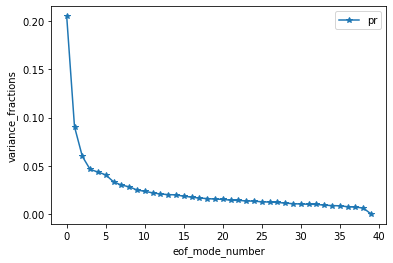

In [338]:
varfrac_prfull.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_prfull[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_prfull.totalAnomalyVariance())

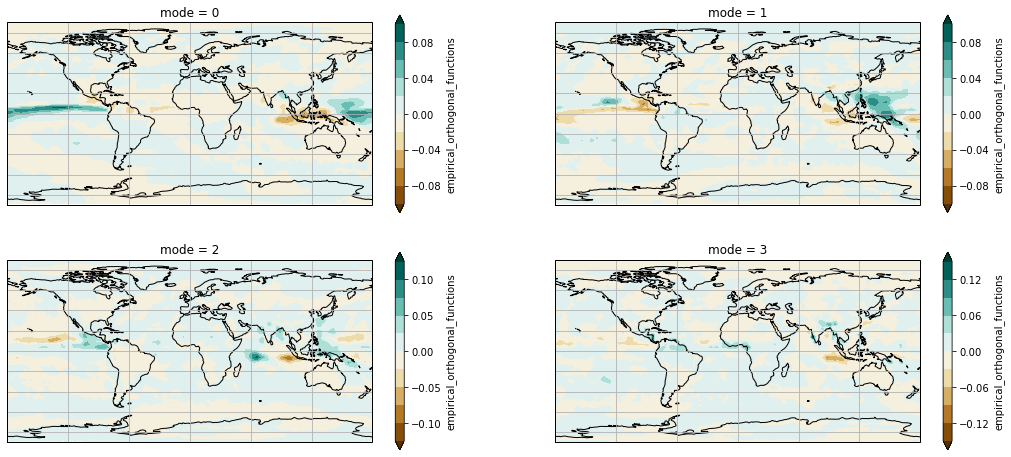

In [339]:
plt.figure(figsize=(18,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_prfull[i,:,:].plot.contourf(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([-180,180,-90,90],crs=ccrs.PlateCarree())

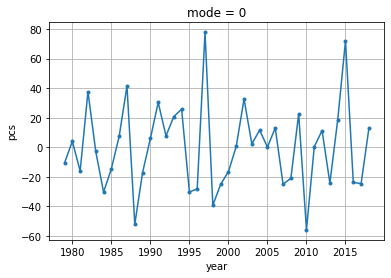

In [340]:
pcs_prfull.sel(mode=0).plot(marker='.')
plt.grid()

sum of variance in first 4 pr EOFs =  0.5901574
total anomaly variance pr = 238.5307


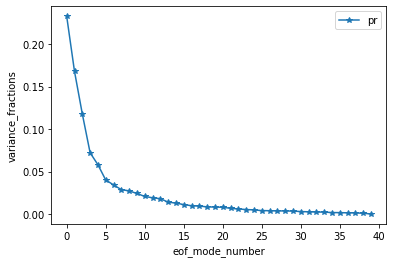

In [341]:
varfrac_pr.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_pr[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr.totalAnomalyVariance())

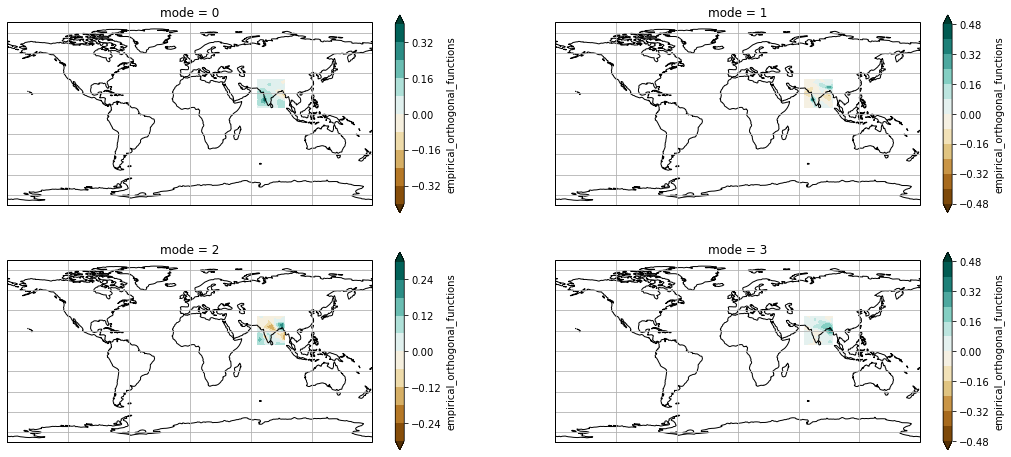

In [342]:
plt.figure(figsize=(18,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_pr[i,:,:].plot.contourf(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([-180,180,-90,90],crs=ccrs.PlateCarree())

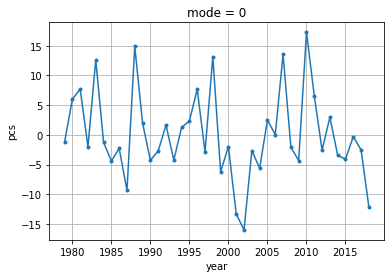

In [343]:
pcs_pr.sel(mode=0).plot(marker='.')
plt.grid()

# different GPCP dataset

In [344]:
# first load your data

dirn = '/global/scratch/williamb/forOthers/forMedha/GPCP_CDR/Monthly_Data/'
filen = 'gpcp_cdr_v23rB1_y*.nc'
datgpcp = xr.open_mfdataset(dirn+filen,combine='by_coords')
# precip units are mm/day:
prgpcp = datgpcp['precip']
prgpcp = prgpcp.rename({
    "nlat": "lat",
    "nlon": "lon",
    "latitude":"lat",
    "longitude":"lon"
})

# select years of interest (dataset only goes thru march 2019):
prgpcp = prgpcp.sel(time=slice('1979-01-01','2018-12-31'))

In [345]:
# take summer mean:
def is_summer(month):
    return (month >= 6) & (month <= 9)
prgpcpSeas = prgpcp.sel(time=is_summer(prgpcp['time.month']))#.groupby('time.year').mean()

prgpcpSeas = prgpcpSeas.groupby('time.year',restore_coord_dims = True).mean("time")
print(prgpcpSeas.dims)
print(prgpcp.dims)
# rechunk data for efficiency:
prgpcpSeas.data = prgpcpSeas.data.rechunk(-1)

# eliminate any NaNs:
prgpcpSeas = prgpcpSeas.ffill('lon').bfill('lon').ffill('lat').bfill('lat')
prgpcpSeas.load()

('year', 'lat', 'lon')
('time', 'lat', 'lon')


<xarray.DataArray 'precip' (year: 40, lat: 72, lon: 144)>
array([[[0.616269, 0.647796, ..., 0.603927, 0.587555],
        [0.541122, 0.565236, ..., 0.556403, 0.559585],
        ...,
        [0.505192, 0.511057, ..., 0.532338, 0.507112],
        [0.652965, 0.606779, ..., 0.689252, 0.705681]],

       [[0.894309, 0.928503, ..., 0.874586, 0.862789],
        [0.718108, 0.745002, ..., 0.74288 , 0.742798],
        ...,
        [0.45254 , 0.460124, ..., 0.474926, 0.452624],
        [0.654911, 0.608544, ..., 0.685029, 0.702256]],

       ...,

       [[1.382706, 1.380272, ..., 1.381902, 1.378865],
        [1.306335, 1.314766, ..., 1.299515, 1.300722],
        ...,
        [0.523463, 0.512078, ..., 0.565156, 0.541787],
        [0.844637, 0.831877, ..., 0.858184, 0.852643]],

       [[1.091924, 1.093881, ..., 1.086931, 1.089991],
        [0.939637, 0.946683, ..., 0.924246, 0.932385],
        ...,
        [0.17032 , 0.161231, ..., 0.192031, 0.180302],
        [0.445276, 0.442859, ..., 0.462906, 0.

In [346]:
latlim1 = 90
latlim2 = -90

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2))
# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)
print(coslat2)

<xarray.DataArray 'lat' (year: 40, lat: 72, lon: 144)>
array([[[0.021815, 0.021815, ..., 0.021815, 0.021815],
        [0.065403, 0.065403, ..., 0.065403, 0.065403],
        ...,
        [0.065403, 0.065403, ..., 0.065403, 0.065403],
        [0.021815, 0.021815, ..., 0.021815, 0.021815]],

       [[0.021815, 0.021815, ..., 0.021815, 0.021815],
        [0.065403, 0.065403, ..., 0.065403, 0.065403],
        ...,
        [0.065403, 0.065403, ..., 0.065403, 0.065403],
        [0.021815, 0.021815, ..., 0.021815, 0.021815]],

       ...,

       [[0.021815, 0.021815, ..., 0.021815, 0.021815],
        [0.065403, 0.065403, ..., 0.065403, 0.065403],
        ...,
        [0.065403, 0.065403, ..., 0.065403, 0.065403],
        [0.021815, 0.021815, ..., 0.021815, 0.021815]],

       [[0.021815, 0.021815, ..., 0.021815, 0.021815],
        [0.065403, 0.065403, ..., 0.065403, 0.065403],
        ...,
        [0.065403, 0.065403, ..., 0.065403, 0.065403],
        [0.021815, 0.021815, ..., 0.021815, 0.021

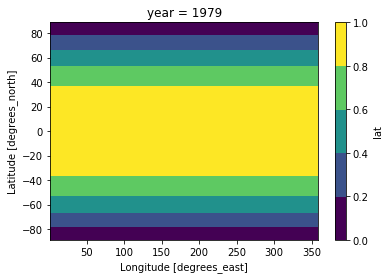

In [347]:
coslat2[0,:,:].plot.contourf()

In [348]:
# find the EOFs
solver_prfull = Eof(tmppr,weights=coslat2,center=True)
pcs_prfull = solver_prfull.pcs()
eofs_prfull = solver_prfull.eofs()
varfrac_prfull = solver_prfull.varianceFraction()

In [349]:
#(5-35n, 65-95e)
latlim1 = 35
latlim2 = 5
lonlim1 = 65
lonlim2 = 95

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))
# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_pr = Eof(tmppr,weights=coslat2,center=True)
pcs_pr = solver_pr.pcs()
eofs_pr = solver_pr.eofs()
varfrac_pr = solver_pr.varianceFraction()

sum of variance in first 4 pr EOFs =  0.40173125
total anomaly variance pr = 4218.7524


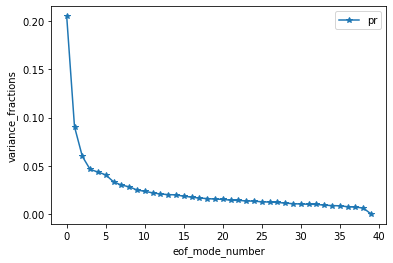

In [350]:
varfrac_prfull.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_prfull[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_prfull.totalAnomalyVariance())

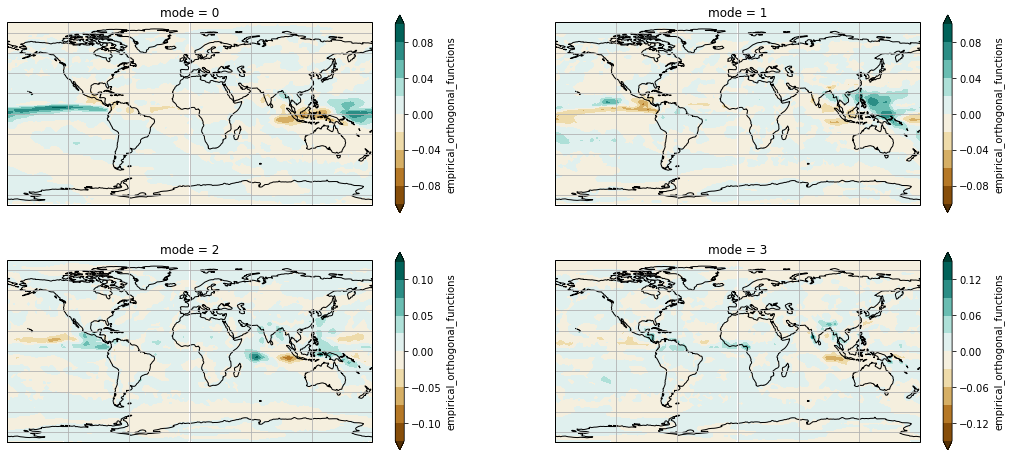

In [351]:
plt.figure(figsize=(18,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_prfull[i,:,:].plot.contourf(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([-180,180,-90,90],crs=ccrs.PlateCarree())

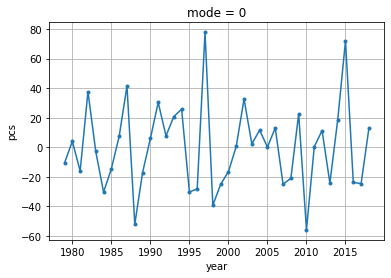

In [352]:
pcs_prfull.sel(mode=0).plot(marker='.')
plt.grid()

sum of variance in first 4 pr EOFs =  0.6197351
total anomaly variance pr = 1905.9778


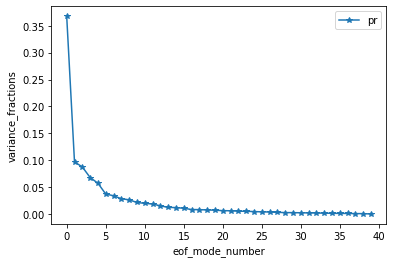

In [353]:
varfrac_pr.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_pr[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr.totalAnomalyVariance())

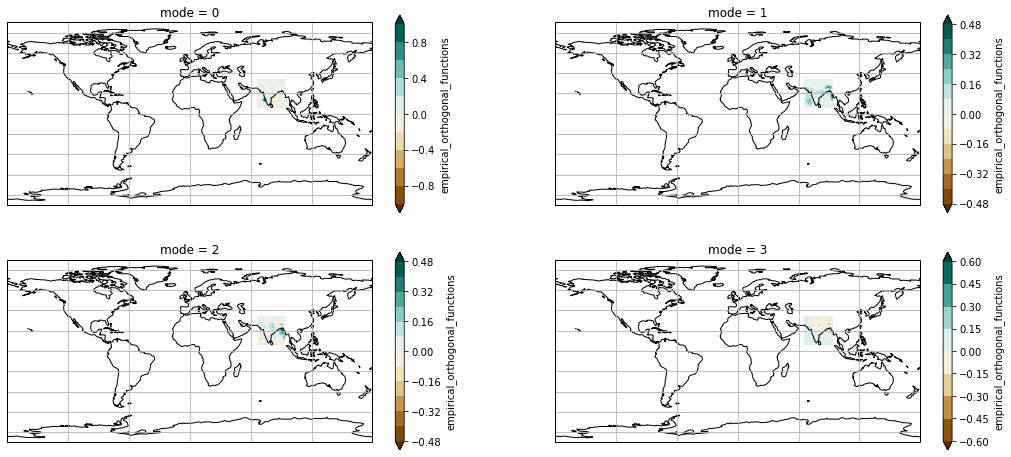

In [354]:
plt.figure(figsize=(18,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_pr[i,:,:].plot.contourf(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([-180,180,-90,90],crs=ccrs.PlateCarree())

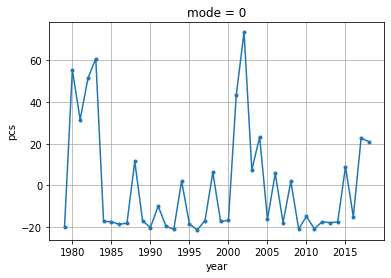

In [355]:
pcs_pr.sel(mode=0).plot(marker='.')
plt.grid()

In [357]:
#coslat2[0,:,:].plot.contourf()

In [358]:
# Copyright (c) 2020 Medha Palavalli.